In [1]:
import os, pandas as pd, numpy as np
from fredapi import Fred
import matplotlib.pyplot as plt
fred = Fred(api_key=os.getenv('FRED_API_KEY'))

In [2]:
verified_series = {
    'Recession': 'USREC',
    '10Y Treasury': 'GS10',
    '3Y Treasury': 'TB3MS',
    'Unemployment': 'UNRATE',
    'Interest Rates': 'FEDFUNDS',
    'CPI': 'CPIAUCSL',
    'Real_DPI': 'DSPIC96',
    'PCE': 'PCE',
    'Sentiment': 'UMCSENT',
    'Industrial Production' : 'INDPRO',
    'Housing Starts' : 'HOUST',
    'Money Supply' : 'M2SL',
    'PPI' : 'PPIACO'
}

# Test the series to make usre I got the names right
for name, sid in verified_series.items():
    try:
        data = fred.get_series(sid)
        print(f"✓ {name} ({sid}): SUCCESS")
    except Exception as e:
        print(f"✗ {name} ({sid}): FAILED - {e}")

✓ Recession (USREC): SUCCESS
✓ 10Y Treasury (GS10): SUCCESS
✓ 3Y Treasury (TB3MS): SUCCESS
✓ Unemployment (UNRATE): SUCCESS
✓ Interest Rates (FEDFUNDS): SUCCESS
✓ CPI (CPIAUCSL): SUCCESS
✓ Real_DPI (DSPIC96): SUCCESS
✓ PCE (PCE): SUCCESS
✓ Sentiment (UMCSENT): SUCCESS
✓ Industrial Production (INDPRO): SUCCESS
✓ Housing Starts (HOUST): SUCCESS
✓ Money Supply (M2SL): SUCCESS
✓ PPI (PPIACO): SUCCESS


In [3]:
df = pd.DataFrame({name: fred.get_series(sid) for name, sid in verified_series.items()})
df.index = pd.to_datetime(df.index)
df = df.resample('ME').mean()
df = df[df.index >= '1955-01-01']
df['10-3Spread'] = df['10Y Treasury']- df['3Y Treasury']
df = df.dropna()
df

,Recession,10Y Treasury,3Y Treasury,Unemployment,Interest Rates,CPI,Real_DPI,PCE,Sentiment,Industrial Production,Housing Starts,Money Supply,PPI,10-3Spread
1959-05-31,0.0,4.31,2.84,5.1,2.90,29.040,2366.6,316.1,95.3,23.5885,1498.0,292.2,31.800,1.47
1959-11-30,0.0,4.53,4.15,5.8,4.00,29.350,2376.6,322.9,93.8,22.2152,1416.0,297.1,31.500,0.38
1960-02-29,0.0,4.49,3.96,4.8,3.97,29.410,2405.3,325.3,100.0,23.9924,1503.0,298.4,31.600,0.53
1960-05-31,1.0,4.35,3.29,5.1,3.85,29.570,2422.6,330.0,93.3,23.5616,1271.0,300.9,31.700,1.06
1960-08-31,1.0,3.80,2.30,5.6,2.98,29.610,2423.3,331.6,97.2,23.1577,1344.0,306.9,31.600,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.0,4.28,4.21,4.2,4.33,320.321,18168.6,20746.4,52.2,101.1279,1398.0,21770.6,258.392,0.07
2025-05-31,0.0,4.42,4.25,4.2,4.33,320.580,18041.7,20755.0,52.2,100.9655,1282.0,21827.5,258.678,0.17
2025-06-30,0.0,4.38,4.23,4.1,4.33,321.500,18036.2,20868.4,60.7,101.4785,1382.0,21942.5,260.482,0.15
2025-07-31,0.0,4.39,4.25,4.2,4.33,322.132,18084.5,20981.2,61.7,101.8738,1429.0,22028.7,262.363,0.14


In [4]:
from statsmodels.tsa.stattools import adfuller
def adf_stationing(series, use_log=False):
    """
    Tests stationarity step-by-step:
    1. Raw series
    2. Log(series) if use_log=True
    3. Diff(log(series)) or Diff(series)
    
    Returns:
        stationary_series, message
    """
    print("ADF TEST")
    
    # Clean NA
    curr_series = series.dropna()
    
    # STEP 1 — Test raw series
    result = adfuller(curr_series)
    print(f"Raw p-value: {result[1]:.5f}")
    
    if result[1] <= 0.05:
        return curr_series
    
    # ==========================
    # STEP 2 — Log transform, Not all data needs log transform, only if we know it grows exponentially
    # ==========================
    if use_log:
        # only log once
        curr_series = np.log(curr_series)
        curr_series = curr_series.dropna()
        result = adfuller(curr_series)
        print(f"Log p-value: {result[1]:.5f}")
        
        if result[1] <= 0.05:
            
            return curr_series
    
    # ==========================
    # STEP 3 — First difference
    # ==========================
    curr_series = curr_series.diff().dropna()
    result = adfuller(curr_series)
    print(f"1st Difference p-value: {result[1]:.5f}")
    
    if result[1] <= 0.05:
       
        return curr_series
    
    # ==========================
    # STEP 4 — Second difference (optional)
    # ==========================
    curr_series = curr_series.diff().dropna()
    result = adfuller(curr_series)
    print(f"2nd Difference p-value: {result[1]:.5f}")
    
    if result[1] <= 0.05:
        
        return curr_series 
    
    # ==========================
    # If still not stationary
    # ==========================
    return None, "ERROR: Still not stationary — consider seasonal differencing or detrending"


In [5]:
log_candidates = [
    'CPI', 'Real_DPI', 'PCE', 
    'Industrial Production', 'Housing Starts', 
    'Money Supply', 'PPI'
]

no_log_candidates = [
    '10Y Treasury', '3Y Treasury', 'Unemployment', 
    'Interest Rates', 'Sentiment', '10-3Spread'
]

station_data = {}


print(f"{'Variable':<25} | {'Transformation Used'}")
print("-" * 60)

for col in df.columns:
    # A. SKIP THE TARGET
    if col == 'Recession':
        station_data[col] = df[col]
        continue

    # B. Determine if we should attempt Log
    use_log = col in log_candidates

    # C. Run ADF Function
    # We wrap this in a try/except because your function returns different types
    try:
        result = adf_stationing(df[col], use_log=use_log)
        
        # Check if result is a Tuple (Error) or Series (Success)
        if isinstance(result, tuple):
            print(f"❌ {col:<24} | FAILED to make stationary")
        else:
            station_data[col] = result
            
            # Diagnostic print to see what happened
            # If length matches original -> Raw
            # If length is original - 1 -> 1st Diff
            diff_len = len(df) - len(result)
            status = "Raw" if diff_len == 0 else f"{diff_len}x Differenced"
            if use_log and diff_len > 0: status = "Log + " + status
            print(f"✅ {col:<24} | {status}")

    except Exception as e:
        print(f"⚠️ {col:<24} | Error: {e}")

# 4. Create the final DataFrame
station_df = pd.concat(station_data.values(), axis=1, keys=station_data.keys())

# 5. Clean up the NaNs created by differencing (drop the first 1-2 rows)
station_df = station_df.dropna()

print("\nFinal Data Shape:", station_df.shape)
station_df

Variable                  | Transformation Used
------------------------------------------------------------
ADF TEST
Raw p-value: 0.57740
1st Difference p-value: 0.00000
✅ 10Y Treasury             | 1x Differenced
ADF TEST
Raw p-value: 0.27177
1st Difference p-value: 0.00000
✅ 3Y Treasury              | 1x Differenced
ADF TEST
Raw p-value: 0.02369
✅ Unemployment             | Raw
ADF TEST
Raw p-value: 0.22557
1st Difference p-value: 0.00000
✅ Interest Rates           | 1x Differenced
ADF TEST
Raw p-value: 0.98233
Log p-value: 0.00371
✅ CPI                      | Raw
ADF TEST
Raw p-value: 0.99407
Log p-value: 0.04207
✅ Real_DPI                 | Raw
ADF TEST
Raw p-value: 1.00000
Log p-value: 0.00244
✅ PCE                      | Raw
ADF TEST
Raw p-value: 0.09965
1st Difference p-value: 0.00000
✅ Sentiment                | 1x Differenced
ADF TEST
Raw p-value: 0.19706
Log p-value: 0.00019
✅ Industrial Production    | Raw
ADF TEST
Raw p-value: 0.12410
Log p-value: 0.07123
1st Difference p-

,Recession,10Y Treasury,3Y Treasury,Unemployment,Interest Rates,CPI,Real_DPI,PCE,Sentiment,Industrial Production,Housing Starts,Money Supply,PPI,10-3Spread
1959-11-30,0.0,0.22,1.31,5.8,1.10,3.379293,7.773426,5.777343,-1.5,3.100777,-0.056295,5.694069,3.449988,0.38
1960-02-29,0.0,-0.04,-0.19,4.8,-0.03,3.381335,7.785430,5.784748,6.2,3.177737,0.059627,5.698435,3.453157,0.53
1960-05-31,1.0,-0.14,-0.67,5.1,-0.12,3.386760,7.792597,5.799093,-6.7,3.159618,-0.167659,5.706778,3.456317,1.06
1960-08-31,1.0,-0.55,-0.99,5.6,-0.87,3.388112,7.792886,5.803929,3.9,3.142327,0.055846,5.726522,3.453157,1.50
1960-11-30,1.0,0.13,0.07,6.1,-0.54,3.393837,7.793793,5.815324,-7.1,3.116413,-0.075712,5.739471,3.456317,1.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.0,0.00,0.01,4.2,0.00,5.769324,9.807450,9.940128,-4.8,4.616386,0.031241,9.988316,5.554478,0.07
2025-05-31,0.0,0.14,0.04,4.2,0.00,5.770132,9.800441,9.940542,0.0,4.614779,-0.086621,9.990926,5.555584,0.17
2025-06-30,0.0,-0.04,-0.02,4.1,0.00,5.772998,9.800136,9.945991,8.5,4.619847,0.075110,9.996181,5.562534,0.15
2025-07-31,0.0,0.01,0.02,4.2,0.00,5.774961,9.802810,9.951382,1.0,4.623735,0.033443,10.000101,5.569729,0.14


In [6]:
# Setting up the data with lagged data so we considered different parts of time when we are making predictions, the numbers are chosen to be more relevant
# lags for each index
station_df['Lag 3 Unemployment'] = station_df['Unemployment'].shift(3)
station_df['Lag 12 Interest Rates'] = station_df['Interest Rates'].shift(12)

station_df['Lag 12 CPI'] = station_df['CPI'].shift(12)
station_df['Lag 12 PPI'] = station_df['PPI'].shift(12)

station_df['Lag 3 Sentiment'] = station_df['Sentiment'].shift(3)
station_df['Lag 6 Sentiment'] = station_df['Sentiment'].shift(6)
station_df['Lag 9 Sentiment'] = station_df['Sentiment'].shift(9)

station_df['Lag 12 10-3Spread'] = station_df['10-3Spread'].shift(12)
station_df['Lag 18 10-3Spread'] = station_df['10-3Spread'].shift(18)

station_df['Lag 12 Money Supply'] = station_df['Money Supply'].shift(12)
station_df['Lag 18 Money Supply'] = station_df['Money Supply'].shift(18)

station_df['Lag 6 Housing Starts'] = station_df['Housing Starts'].shift(6)
station_df['Lag 12 Housing Starts'] = station_df['Housing Starts'].shift(12)

station_df['Lag 3 Industrial Production'] = station_df['Industrial Production'].shift(3)
station_df['Lag 6 Industrial Production'] = station_df['Industrial Production'].shift(6)

station_df['Lag 3 PCE'] = station_df['PCE'].shift(3)
station_df['Lag 6 PCE'] = station_df['PCE'].shift(6)

station_df['Lag 3 Real_DPI'] = station_df['Real_DPI'].shift(3)
station_df['Lag 6 Real_DPI'] = station_df['Real_DPI'].shift(6)
station_df = station_df.dropna()
station_df

,Recession,10Y Treasury,3Y Treasury,Unemployment,Interest Rates,CPI,Real_DPI,PCE,Sentiment,Industrial Production,...,Lag 12 Money Supply,Lag 18 Money Supply,Lag 6 Housing Starts,Lag 12 Housing Starts,Lag 3 Industrial Production,Lag 6 Industrial Production,Lag 3 PCE,Lag 6 PCE,Lag 3 Real_DPI,Lag 6 Real_DPI
1964-05-31,0.0,0.05,-0.05,5.1,0.02,3.433342,7.976904,6.012247,-1.0,3.353302,...,5.775172,5.694069,0.066925,0.001630,3.296144,3.249196,5.956614,5.918087,7.912972,7.884765
1964-08-31,0.0,-0.01,0.02,5.0,0.00,3.435599,7.989357,6.034763,2.1,3.369184,...,5.791793,5.698435,-0.107967,0.066166,3.317841,3.267834,5.964607,5.922650,7.928298,7.890695
1964-11-30,0.0,-0.04,0.14,4.8,0.02,3.440739,7.999477,6.031646,-0.7,3.389368,...,5.809343,5.706778,0.119613,0.054147,3.331408,3.295148,5.991964,5.932776,7.942824,7.902857
1965-02-28,0.0,0.06,0.29,5.1,0.46,3.442979,8.011189,6.067036,2.1,3.418018,...,5.829240,5.726522,-0.001220,-0.080404,3.353302,3.296144,6.012247,5.956614,7.976904,7.912972
1965-05-31,0.0,0.00,-0.04,4.6,0.12,3.449352,8.026628,6.081305,3.4,3.443292,...,5.850765,5.739471,-0.010426,0.148771,3.369184,3.317841,6.034763,5.964607,7.989357,7.928298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.0,0.00,0.01,4.2,0.00,5.769324,9.807450,9.940128,-4.8,4.616386,...,9.948891,9.937275,-0.003691,0.054147,4.605817,4.599851,9.926335,9.914724,9.791986,9.787543
2025-05-31,0.0,0.14,0.04,4.2,0.00,5.770132,9.800441,9.940542,0.0,4.614779,...,9.951778,9.937730,-0.043074,-0.051103,4.616103,4.598070,9.929146,9.919046,9.793142,9.789837
2025-06-30,0.0,-0.04,-0.02,4.1,0.00,5.772998,9.800136,9.945991,8.5,4.619847,...,9.954798,9.937952,0.156244,0.008324,4.615520,4.608438,9.937067,9.928877,9.799742,9.790761
2025-07-31,0.0,0.01,0.02,4.2,0.00,5.774961,9.802810,9.951382,1.0,4.623735,...,9.956274,9.941419,-0.108742,-0.047849,4.616386,4.605817,9.940128,9.926335,9.807450,9.791986


In [23]:
class LogisticRegressionFromScratch:
    def __init__(self, learning_rate=0.01, n_iterations=1000, method='GD', verbose=False):
        """
        Args:
            learning_rate: How big of a step to take (only for GD).
            n_iterations: How many times to loop over the data.
            method: 'GD' for Gradient Descent, 'Newton' for Newton's Method.
            verbose: If True, print cost every 100 steps.
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.method = method
        self.verbose = verbose
        self.theta = None  # These are our weights!
        self.cost_history = []

    def _sigmoid(self, z):
        # Clip z to prevent "overflow" errors (computer can't handle e^1000)
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, h, y, lambda_ = 0):
        # This is "Log Loss" (Binary Cross Entropy)
        # We add 1e-15 to avoid taking log(0) which is -Infinity
        m = y.shape[0]
        standard_cost = (-np.sum(y * np.log(h + 1e-15) + (1 - y) * np.log(1 - h + 1e-15)) / m)
        #This is the regularization aspect of the cost
        reg_cost = reg_cost = (lambda_ / (2 * m)) * np.sum(self.theta[1:] ** 2)
        return  reg_cost + standard_cost

    def fit(self, X, y, lambda_=10):
        """
        The Training Loop.
        X: The features (Shape: Rows x Features)
        y: The target labels (Shape: Rows x 1)
        """
        # 1. Add the "Bias" column (column of 1s) to X
        # If X is shape (100, 2), it becomes (100, 3)
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]
        
        m, n = X_bias.shape
        
        # 2. Initialize weights (theta) to zeros
        self.theta = np.zeros(n)
        # 3. The Loop
        for i in range(self.n_iterations):
            # A. PREDICT: Z = X * theta
            z = np.dot(X_bias, self.theta)
            h = self._sigmoid(z) # h is our probability (0 to 1)

            # B. MEASURE: Calculate Gradient (Slope)
            # Gradient = X.T * (Prediction - Actual) / m
            gradient = np.dot(X_bias.T, (h - y)) / m
            theta = self.theta.copy()
            # We don't want to apply our cost formula to the bias column in our weights
            theta[0] = 0
            theta = theta * (lambda_/m)
            gradient = gradient + theta
            # C. UPDATE: Move theta
            if self.method == 'GD':
                # Gradient Descent: Step down the hill
                self.theta -= self.learning_rate * gradient

            elif self.method == 'Newton':
                # Newton's Method: Jump to the bottom
                # Hessian = (X.T * S * X) / m
                S = h * (1 - h)
                theta_matrix = np.eye(n)
                theta_matrix[0][0] = 0
                #Regularization addition
                reg_theta_matrix = theta_matrix * (lambda_/m)
                H = np.dot(X_bias.T, X_bias * S.reshape(-1, 1)) / m
                H = H + reg_theta_matrix
                # Inverse the Hessian
                H_inv = np.linalg.pinv(H)
                
                # Update: theta = theta - H^-1 * gradient
                self.theta -= np.dot(H_inv, gradient)

            # D. LOGGING: Keep track of error
            cost = self._compute_loss(h, y,lambda_)
            self.cost_history.append(cost)

            if self.verbose and i % 100 == 0:
                print(f"Iteration {i}: Cost = {cost:.5f}")

    def predict_proba(self, X):
        """Return raw probabilities"""
        # We must add the bias column here too!
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]
        z = np.dot(X_bias, self.theta)
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        """Return 0 or 1"""
        return (self.predict_proba(X) >= threshold).astype(int)

In [8]:
#Split the data into 2 sets test and train
train_station_df = station_df[station_df.index <= '2005-12-31']
test_station_df = station_df[station_df.index > '2005-12-31']

In [9]:
from sklearn.preprocessing import StandardScaler
# Need to scale the data using training data then transform on the test data
X_train_station_df = train_station_df.drop('Recession', axis = 1)
Y_train_station_df = train_station_df['Recession']

X_test_station_df = test_station_df.drop('Recession', axis = 1)
Y_test_station_df = test_station_df['Recession']

scaler = StandardScaler()

train_station_scaled_values = scaler.fit_transform(X_train_station_df)
test_station_scaled_values = scaler.transform(X_test_station_df)

train_station_scaled = pd.DataFrame(train_station_scaled_values, columns = X_train_station_df.columns, index = X_train_station_df.index)
test_station_scaled = pd.DataFrame(test_station_scaled_values, columns = X_test_station_df.columns, index = X_test_station_df.index)

train_station_scaled

,10Y Treasury,3Y Treasury,Unemployment,Interest Rates,CPI,Real_DPI,PCE,Sentiment,Industrial Production,Housing Starts,...,Lag 12 Money Supply,Lag 18 Money Supply,Lag 6 Housing Starts,Lag 12 Housing Starts,Lag 3 Industrial Production,Lag 6 Industrial Production,Lag 3 PCE,Lag 6 PCE,Lag 3 Real_DPI,Lag 6 Real_DPI
1964-05-31,0.139242,-0.087260,-0.663656,0.024768,-2.588175,-2.576654,-2.586898,-0.238116,-2.667165,-2.658935,...,-2.656623,-2.598040,0.809358,0.003985,-2.775270,-2.838762,-2.578977,-2.549765,-2.686833,-2.685910
1964-08-31,-0.030629,0.032695,-0.732141,-0.002359,-2.583575,-2.539137,-2.557995,0.515463,-2.612411,0.825154,...,-2.634285,-2.592400,-1.331038,0.794797,-2.701936,-2.777103,-2.568907,-2.544120,-2.641497,-2.668698
1964-11-30,-0.115564,0.238332,-0.869111,0.024768,-2.573099,-2.508647,-2.561997,-0.165189,-2.542826,-0.672389,...,-2.610699,-2.581623,1.454168,0.647525,-2.656082,-2.686742,-2.534439,-2.531594,-2.598526,-2.633396
1965-02-28,0.167553,0.495379,-0.663656,0.621559,-2.568532,-2.473361,-2.516570,0.515463,-2.444051,-0.450254,...,-2.583959,-2.556118,-0.024623,-1.001244,-2.582082,-2.683445,-2.508884,-2.502105,-2.497710,-2.604037
1965-05-31,-0.002317,-0.070123,-1.006080,0.160402,-2.555542,-2.426849,-2.498253,0.831480,-2.356918,0.378005,...,-2.555031,-2.539391,-0.137300,1.807023,-2.528402,-2.611667,-2.480515,-2.492217,-2.460873,-2.559554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-31,0.224177,0.375424,-0.800626,0.323163,1.172895,1.535566,1.361463,-1.793892,1.550224,0.240590,...,1.342902,1.310271,0.344736,0.117934,1.537122,1.531852,1.340899,1.330446,1.526319,1.498028
2005-09-30,-0.172188,-0.035851,-0.732141,0.160402,1.200767,1.524954,1.368737,-2.960724,1.482776,0.322074,...,1.350200,1.317866,-2.076874,-0.758495,1.552289,1.527379,1.352728,1.336113,1.532254,1.508298
2005-10-31,0.733789,0.495379,-0.732141,0.214656,1.203840,1.541741,1.374221,-0.651369,1.524369,-0.505500,...,1.356027,1.326439,1.219849,1.013730,1.541570,1.534492,1.367097,1.347570,1.535269,1.517401
2005-11-30,0.224177,0.289741,-0.732141,0.296037,1.193577,1.560504,1.375326,1.803840,1.562904,0.476818,...,1.361597,1.342344,-0.225358,-1.863598,1.552567,1.537468,1.366570,1.346600,1.539993,1.529828


In [10]:
# Running the model
model = LogisticRegressionFromScratch(method='Newton', n_iterations=20, verbose=True)
model.fit(train_station_scaled, Y_train_station_df)

# See the results
print("My Weights:", model.theta)

Iteration 0: Cost = 0.70340
My Weights: [-2.82739582 -0.0176399  -0.10817194  0.63727262 -0.37033133  0.0320236
 -0.07790606 -0.05408351 -0.23878182 -0.1735768  -0.17354194 -0.03954109
  0.17542975  0.02783089 -0.36222328 -0.17367339 -0.0412687   0.03204026
 -0.35434206 -0.26880731 -0.10327979 -0.9084017  -0.61794348 -0.02442249
 -0.02405255 -0.16282506  0.2208448   0.05318207  0.13711375 -0.03711462
 -0.01809381 -0.00317594  0.0238058 ]


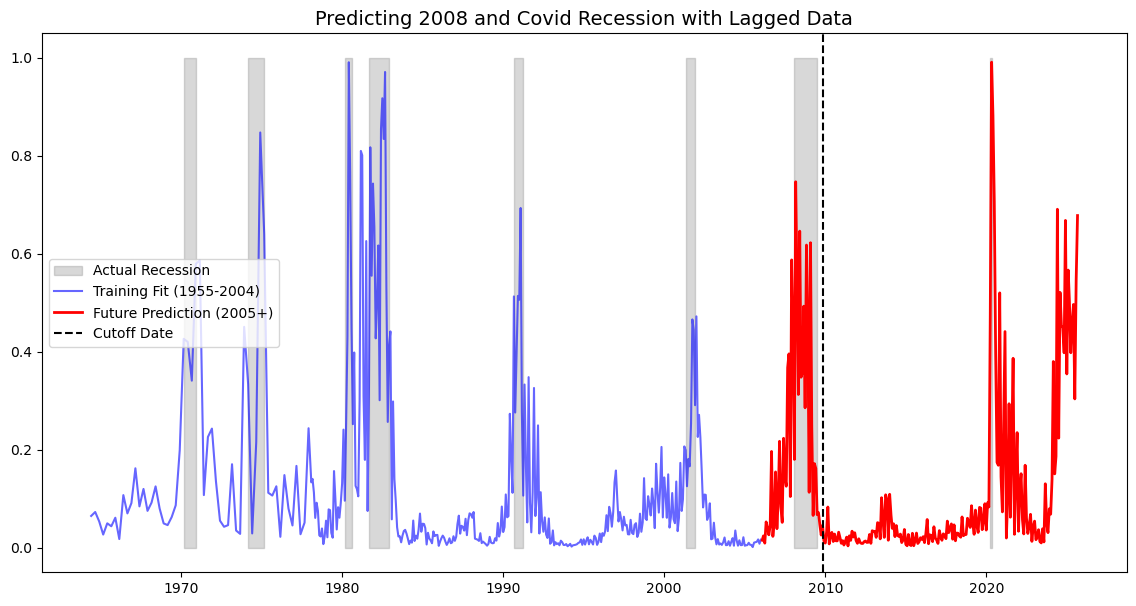

In [11]:
# Get probabilities for BOTH sets
probs_train = model.predict_proba(train_station_scaled)
probs_test = model.predict_proba(test_station_scaled)

# Combine them for plotting
full_probs = np.concatenate([probs_train, probs_test])
full_dates = station_df.index

plt.figure(figsize=(14, 7))

# 1. Plot the actual recessions (Grey Bars)
plt.fill_between(full_dates, 0, 1, where=station_df['Recession']==1, 
                 color='grey', alpha=0.3, label='Actual Recession')

# 2. Plot Training Predictions (Blue) - "The Memory"
plt.plot(train_station_df.index, probs_train, color='blue', alpha=0.6, label='Training Fit (1955-2004)')

# 3. Plot Test Predictions (Red) - "The Forecast"
plt.plot(test_station_df.index, probs_test, color='red', linewidth=2, label='Future Prediction (2005+)')

plt.axvline(pd.to_datetime('2009-10-31'), color='black', linestyle='--', label='Cutoff Date')
plt.title('Predicting 2008 and Covid Recession with Lagged Data', fontsize=14)
plt.legend()
plt.show()

In [25]:
# Running the model
model = LogisticRegressionFromScratch(method='GD', n_iterations=20, verbose=True)
model.fit(train_station_scaled, Y_train_station_df)

# See the results
print("My Weights:", model.theta)

Iteration 0: Cost = 0.69315
My Weights: [-7.41841808e-02 -6.26438460e-03 -1.61294740e-02  1.36783540e-02
 -1.78856888e-02 -4.56931792e-03 -6.86380460e-03 -6.17663140e-03
 -4.83295929e-03 -7.45504483e-03 -2.37979445e-03 -6.14713769e-03
 -1.99280082e-03 -2.66471337e-03  2.78181658e-03  3.94886762e-05
 -5.57177855e-03 -3.43121914e-03 -9.75256517e-03 -6.15738149e-03
 -3.57720861e-03 -2.35735870e-02 -2.34440449e-02 -5.92184277e-03
 -5.82303335e-03 -5.71133990e-03  1.94165007e-03 -4.99073941e-03
 -3.97018510e-03 -5.96397777e-03 -5.78925659e-03 -6.15108324e-03
 -5.76540289e-03]


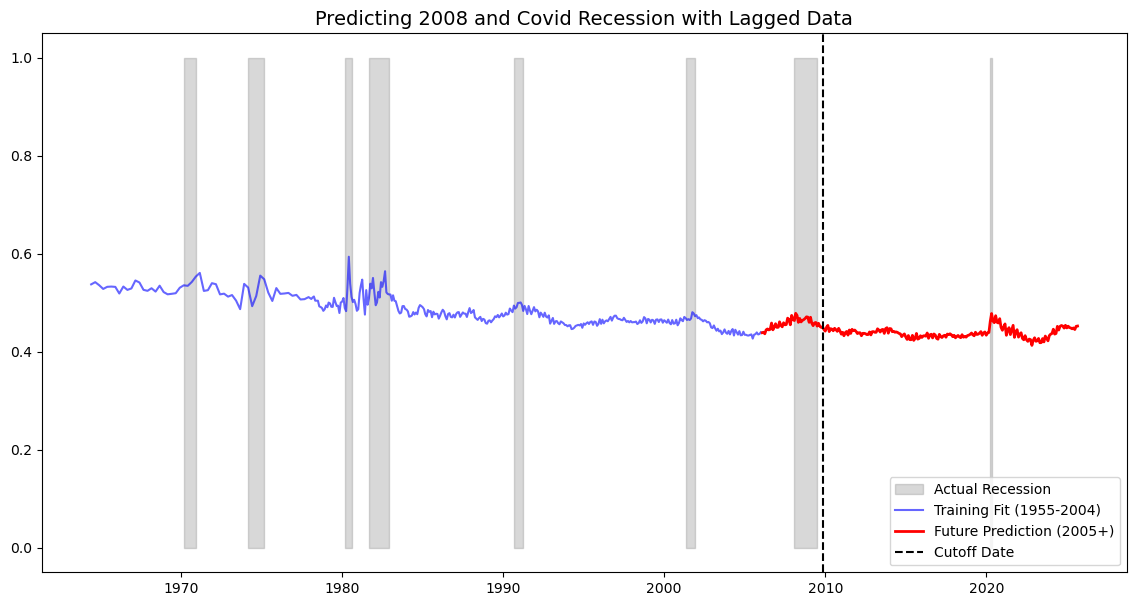

In [27]:
# Get probabilities for BOTH sets
probs_train = model.predict_proba(train_station_scaled)
probs_test = model.predict_proba(test_station_scaled)

# Combine them for plotting
full_probs = np.concatenate([probs_train, probs_test])
full_dates = station_df.index

plt.figure(figsize=(14, 7))

# 1. Plot the actual recessions (Grey Bars)
plt.fill_between(full_dates, 0, 1, where=station_df['Recession']==1, 
                 color='grey', alpha=0.3, label='Actual Recession')

# 2. Plot Training Predictions (Blue) - "The Memory"
plt.plot(train_station_df.index, probs_train, color='blue', alpha=0.6, label='Training Fit (1955-2004)')

# 3. Plot Test Predictions (Red) - "The Forecast"
plt.plot(test_station_df.index, probs_test, color='red', linewidth=2, label='Future Prediction (2005+)')

plt.axvline(pd.to_datetime('2009-10-31'), color='black', linestyle='--', label='Cutoff Date')
plt.title('Predicting 2008 and Covid Recession with Lagged Data', fontsize=14)
plt.legend()
plt.show()